In [17]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from Learners import *
from econml.grf import RegressionForest
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import time

### Data

In [2]:
import pandas as pd
df=pd.read_csv('data.csv',index_col=False)
df.head()

,sex,yob,g2000,g2002,g2004,p2000,p2002,p2004,treatment,cluster,voted,hh_id,hh_size,numberofnames,p2004_mean,g2004_mean
0,male,1941,yes,yes,yes,no,yes,No,Civic Duty,1,No,1.0,2,21,0.095238,0.857143
1,female,1947,yes,yes,yes,no,yes,No,Civic Duty,1,No,1.0,2,21,0.095238,0.857143
2,male,1951,yes,yes,yes,no,yes,No,Hawthorne,1,Yes,2.0,3,21,0.047619,0.857143
3,female,1950,yes,yes,yes,no,yes,No,Hawthorne,1,Yes,2.0,3,21,0.047619,0.857143
4,female,1982,yes,yes,yes,no,yes,No,Hawthorne,1,Yes,2.0,3,21,0.047619,0.857143


In [3]:
df.loc[df['sex']=='male', 'sex']=0
df.loc[df['sex']=='female', 'sex']=1
df['age']=2019-df['yob']
for item in ['g2000','g2002','p2000','p2002','p2004','voted']:
    df.loc[df[item]=='yes', item]=1
    df.loc[df[item]=='Yes', item]=1
    df.loc[df[item]=='no', item]=0
    df.loc[df[item]=='No', item]=0

In [4]:
# Neighbors
df = df[(df['treatment']==' Control') | (df['treatment']==' Neighbors')]
df.loc[df['treatment']==' Control', 'treatment']=0
df.loc[df['treatment']==' Neighbors', 'treatment']=1

In [5]:
df.head()

,sex,yob,g2000,g2002,g2004,p2000,p2002,p2004,treatment,cluster,voted,hh_id,hh_size,numberofnames,p2004_mean,g2004_mean,age
5,0,1981,0,0,yes,0,0,0,0,1,0,3.0,3,21,0.047619,0.904762,38
6,1,1959,1,1,yes,0,1,0,0,1,1,3.0,3,21,0.047619,0.904762,60
7,0,1956,1,1,yes,0,1,0,0,1,1,3.0,3,21,0.047619,0.904762,63
8,1,1968,0,0,yes,0,1,0,0,1,0,4.0,2,21,0.047619,0.904762,51
9,0,1967,1,1,yes,0,1,0,0,1,0,4.0,2,21,0.047619,0.904762,52


In [6]:
X=np.array(df[['sex','age','g2000','g2002','p2000','p2002','p2004']], dtype=np.int)
y=np.array(df['voted'],dtype=np.int)
treatment=np.array(df['treatment'],dtype=np.int)

In [7]:
print(X[treatment==1].shape,X[treatment==0].shape)

(38201, 7) (191243, 7)


In [8]:
38201/(191243+38201)

0.16649378497585468

### Figure 2

In [51]:
from copy import deepcopy
def get_ci(learner):
    learner_ = deepcopy(learner)
    cate_mean=learner_.get_cate(X,y, treatment)
    
    idx0=np.where(treatment==0)[0]
    idx1=np.where(treatment==1)[0]
    cate_ = []
    B=100
    for i in range(B):
        sam0 = random.choices(idx0,k=len(idx0))
        sam1 = random.choices(idx1,k=len(idx1))
        Xtrain = np.concatenate((X[sam0],X[sam1]),axis=0)
        ytrain = np.concatenate((y[sam0],y[sam1]),axis=0)
        ttrain = np.concatenate((treatment[sam0],treatment[sam1]),axis=0)
    
        learner_ = deepcopy(learner)
        cate_.append(learner_.get_cate(Xtrain,ytrain, ttrain))
        
    cate_ = np.array(cate_)
    cate_std = np.std(cate_, axis=0)
    CI_upper = cate_mean+1.96*cate_std
    CI_lower = cate_mean-1.96*cate_std
    return cate_mean, CI_lower, CI_upper

In [ ]:
mean_x, lower_x, upper_x = get_ci(learner=BaseXClassifier(learner=RegressionForest(), cate_learner=RegressionForest(), type_=1))

In [44]:
mean_t, lower_t, upper_t = get_ci(learner=BaseTClassifier(learner0=RegressionForest(), learner1=RegressionForest(), type_=1))

In [52]:
mean_s, lower_s, upper_s = get_ci(learner=BaseSClassifier(learner=RegressionForest(), type_=1))

In [34]:
df['group']=df['g2000']+df['g2002']+df['p2000']+df['p2002']+df['p2004']
df = df.reset_index()
g0idx = df.loc[df['group']==0].index
g1idx = df.loc[df['group']==1].index
g2idx = df.loc[df['group']==2].index
g3idx = df.loc[df['group']==3].index
g4idx = df.loc[df['group']==4].index
g5idx = df.loc[df['group']==5].index
len(g5idx)+len(g4idx)+len(g3idx)+len(g2idx)+len(g1idx)+len(g0idx)==len(X)

True

In [35]:
def plot_fig2(cate, lower, upper):
    #Find  the percentage of voters for which the predicted CATE is significantly positive
    pos = [len([ele for ele in lower[g0idx] if ele > 0]) / len(g0idx),
           len([ele for ele in lower[g1idx] if ele > 0]) / len(g1idx),
           len([ele for ele in lower[g2idx] if ele > 0]) / len(g2idx),
           len([ele for ele in lower[g3idx] if ele > 0]) / len(g3idx),
           len([ele for ele in lower[g4idx] if ele > 0]) / len(g4idx),
           len([ele for ele in lower[g5idx] if ele > 0]) / len(g5idx)]
    #Find  the percentage of voters for which the predicted CATE is significantly negative
    neg = [-len([ele for ele in upper[g0idx] if ele < 0]) / len(g0idx),
           -len([ele for ele in upper[g1idx] if ele < 0]) / len(g1idx),
           -len([ele for ele in upper[g2idx] if ele < 0]) / len(g2idx),
           -len([ele for ele in upper[g3idx] if ele < 0]) / len(g3idx),
           -len([ele for ele in upper[g4idx]if ele < 0]) / len(g4idx),
           -len([ele for ele in upper[g5idx] if ele < 0]) / len(g5idx)]
    #The width of each group is proportional to the size of the group
    sizes=[len(g0idx),len(g1idx),len(g2idx),len(g3idx),len(g4idx),len(g5idx)]
    fig, ax = plt.subplots(2)
    ax[0].set_ylabel('Voter Proportion')
    ax[1].set_ylabel('CATE')
    ax[1].set_xlabel('Cumulative Voting History')
    #ax[1].set_xticks(np.arange(6))
    ax[0].bar(np.arange(6),pos, width=sizes/np.sum(sizes)*2, color='b', bottom=[0,0,0,0,0,0])
    ax[0].bar(np.arange(6),neg, width=sizes/np.sum(sizes)*2, color='r')
    ax[1].boxplot(np.array([cate[g0idx],cate[g1idx],cate[g2idx],cate[g3idx],cate[g4idx],cate[g5idx]]),showfliers=False,widths=sizes/np.sum(sizes)*2)
    ax[0].axhline(y=0.0, color='black', linestyle='-')
    ax[1].axhline(y=0.0, color='black', linestyle='-')

/usr/local/stow/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


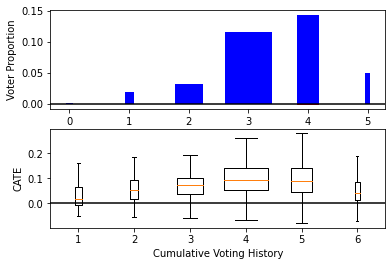

In [47]:
plot_fig2(mean_x, lower_x, upper_x)

/usr/local/stow/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


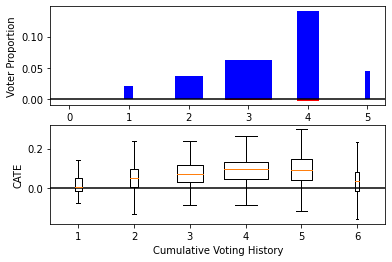

In [50]:
plot_fig2(mean_t, lower_t, upper_t)

/usr/local/stow/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


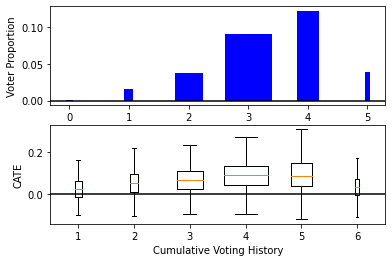

In [53]:
plot_fig2(mean_s, lower_s, upper_s)

In [54]:
np.corrcoef(mean_t, mean_s)

array([[1.        , 0.92527133],
       [0.92527133, 1.        ]])

### Figure3

In [19]:
def get_sample(i):
    len0, len1 = int(i*len(X[treatment==0])), int(i*len(X[treatment==1]))
    ind0 = np.random.choice(len(X_0),len0,replace=False)
    ind1 = np.random.choice(len(X_1),len1,replace=False)
    Xtrain = np.concatenate((X_0[ind0],X_1[ind1]),axis=0)
    ytrain = np.concatenate((y_0[ind0],y_1[ind1]),axis=0)
    #Xtest = np.concatenate((X_0[np.delete(np.arange(len(X_0)),ind0)],X_1[np.delete(np.arange(len(X_1)),ind1)]),axis=0)
    return len0, len1,Xtrain, ytrain

In [107]:
def eval(cate,gt):
    rmse, variance, bias = [],[],[]
    for i in range(len(sample)):
        variance.append(np.var(cate[i]))
        rmse.append(mean_squared_error(gt[i], cate[i], squared=False))
        #bias.append(np.sqrt(max(0,rmse[-1]**2-variance[-1])))
        #bias.append(np.sqrt(np.mean((gt[i]-np.mean(cate[i]))**2)))
        #bias.append(np.abs(np.mean(cate[i])-np.mean(gt[i])))
        bias.append(np.mean(np.abs(cate[i]-gt[i])))
    return rmse, variance, bias

In [21]:
def visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3):
    x = 1/1000*len(X)*np.array(sample)
    fig, ax = plt.subplots(3, 1, figsize=(12, 8),sharex=True,subplot_kw=dict(frameon=False))
    ax[0].plot(x, v2, color="green", marker=".", label="S-Learner")
    ax[1].plot(x, b2, color="green",marker=".",label="S-Learner")
    ax[2].plot(x, r2, color="green", marker=".", label="S-Learner")
    ax[0].plot(x, v1, color="grey", marker="^", label="T-Learner")
    ax[1].plot(x, b1, color="grey",marker="^",label="T-Learner")
    ax[2].plot(x, r1, color="grey", marker="^", label="T-Learner")
    ax[0].plot(x, v3, color="blue", marker="|", label="X-Learner")
    ax[1].plot(x, b3, color="blue",marker="|",label="X-Learner")
    ax[2].plot(x, r3, color="blue", marker="|", label="X-Learner")
    ax[0].legend(bbox_to_anchor=(1.05, 0), loc='upper left', ncol=1)
    ax[0].set_ylabel('Average Variance')
    ax[1].set_ylabel('Average Bias')
    ax[2].set_ylabel('RMSE')
    ax[2].set_xlabel('Training Size (in 1000)')
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    fig.show()

In [22]:
def visualize2(r1,v1,b1,r2,v2,b2):
    x = 1/1000*len(X)*np.array(sample)
    fig, ax = plt.subplots(3, 1, figsize=(12, 8),sharex=True,subplot_kw=dict(frameon=False))
    ax[0].plot(x, v2, color="green", marker=".", label="S-Learner")
    ax[1].plot(x, b2, color="green",marker=".",label="S-Learner")
    ax[2].plot(x, r2, color="green", marker=".", label="S-Learner")
    ax[0].plot(x, v1, color="grey", marker="^", label="T-Learner")
    ax[1].plot(x, b1, color="grey",marker="^",label="T-Learner")
    ax[2].plot(x, r1, color="grey", marker="^", label="T-Learner")
    ax[0].legend(bbox_to_anchor=(1.05, 0), loc='upper left', ncol=1)
    ax[0].set_ylabel('Average Variance')
    ax[1].set_ylabel('Average Bias')
    ax[2].set_ylabel('RMSE')
    ax[2].set_xlabel('Training Size (in 1000)')
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    fig.show()

In [119]:
idx=np.arange(len(y))
random.shuffle(idx)
X = X[idx]
y = y[idx]
treatment = treatment[idx]
ratio = len(X[treatment==1])/(len(X[treatment==0])+len(X[treatment==1]))
t = 50000
b = int(ratio*t)
a = t-b
Xtest = np.concatenate((X[treatment==0][:a],X[treatment==1][:b]),axis=0)
ytest = np.concatenate((y[treatment==0][:a],y[treatment==1][:b]),axis=0)
treatment_test = np.array([0]*a+[1]*b)
X_0, X_1, y_0,y_1 = X[treatment==0][a:], X[treatment==1][b:], y[treatment==0][a:],y[treatment==1][b:]
#X_0, X_1, y_0,y_1 = X[treatment==0], X[treatment==1], y[treatment==0],y[treatment==1]
learner_t_gt = BaseTClassifier(learner0=RegressionForest(), learner1=RegressionForest(), type_=1)
learner_t_gt.fit(X,y,treatment)
sample = [0.002,0.005,0.008,0.01,0.02,0.05,0.1,0.2,0.3]

In [ ]:
N = 2

89.29384565353394


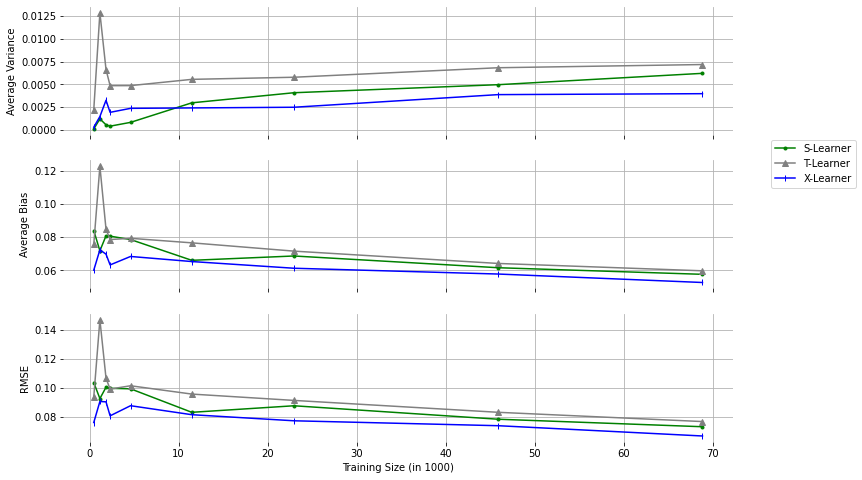

In [120]:
# honest rf
s = time.time()
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0,len1,Xtrain, ytrain = get_sample(i)
    gt_curr,cate_t_curr,cate_s_curr,cate_x_curr = np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t)
    for j in range(N):
        gt_curr += learner_t_gt.get_cate2(Xtrain,ytrain,Xtest,len0, len1,0).reshape(-1)
        learner_t = BaseTClassifier(learner0=RegressionForest(), learner1=RegressionForest(), type_=1)
        cate_t_curr += learner_t.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1)
        learner_s = BaseSClassifier(learner=RegressionForest(), type_=1)
        cate_s_curr += learner_s.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1)
        learner_x = BaseXClassifier(learner=RegressionForest(), cate_learner=RegressionForest(), type_=1)
        cate_x_curr += learner_x.get_cate2(Xtrain,ytrain,Xtest,len0, len1, treatment_test)
    cate_t.append(cate_t_curr/N)
    cate_s.append(cate_s_curr/N)
    cate_x.append(cate_x_curr/N)
    gt.append(gt_curr/N)
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
r3,v3,b3 = eval(cate_x,gt)
visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3)
print(time.time()-s)

146.15295505523682


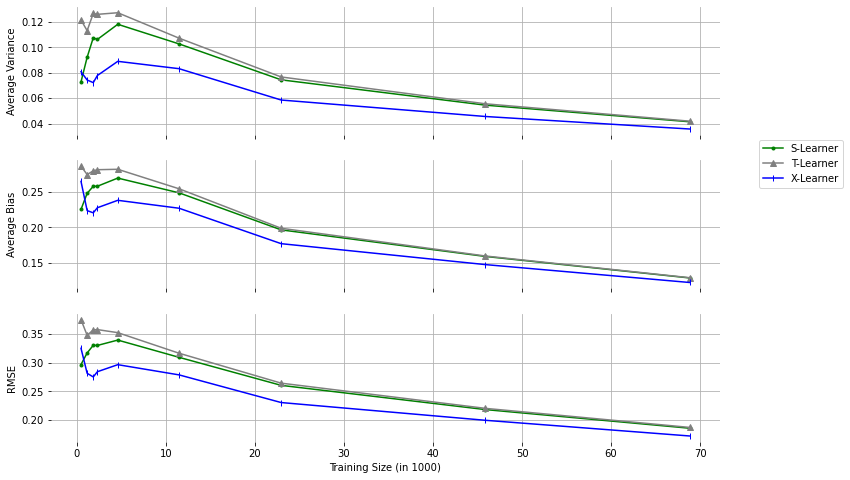

In [121]:
# rf
s = time.time()
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0,len1,Xtrain, ytrain = get_sample(i)
    gt_curr,cate_t_curr,cate_s_curr,cate_x_curr = np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t)
    for j in range(N):
        gt_curr += learner_t_gt.get_cate2(Xtrain,ytrain,Xtest,len0, len1,0).reshape(-1)
        learner_t = BaseTClassifier(learner0=RandomForestClassifier(), learner1=RandomForestClassifier())
        cate_t_curr += learner_t.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1)
        learner_s = BaseSClassifier(learner=RandomForestClassifier())
        cate_s_curr += learner_s.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1)
        learner_x =BaseXClassifier(learner=RandomForestClassifier(), cate_learner=RandomForestRegressor(), prospensity_learner=RandomForestClassifier())
        cate_x_curr += learner_x.get_cate2(Xtrain,ytrain,Xtest,len0, len1, treatment_test)
    cate_t.append(cate_t_curr/N)
    cate_s.append(cate_s_curr/N)
    cate_x.append(cate_x_curr/N)
    gt.append(gt_curr/N)
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
r3,v3,b3 = eval(cate_x,gt)
visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3)
print(time.time()-s)

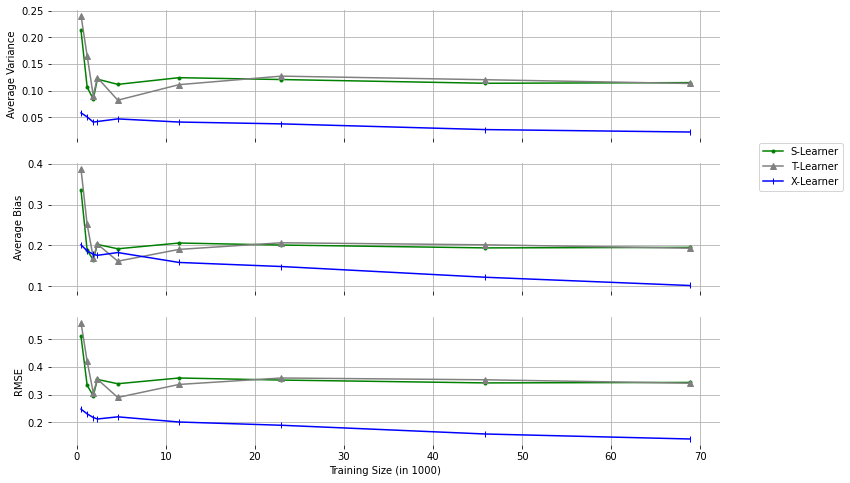

In [122]:
# lr
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0, len1 = int(i*len(X[treatment==0])), int(i*len(X[treatment==1]))
    ind0 = np.random.choice(len(X_0),len0,replace=False)
    ind1 = np.random.choice(len(X_1),len1,replace=False)
    Xtrain = np.concatenate((X_0[ind0],X_1[ind1]),axis=0)
    ytrain = np.concatenate((y_0[ind0],y_1[ind1]),axis=0)
    #Xtest = np.concatenate((X_0[np.delete(np.arange(len(X_0)),ind0)],X_1[np.delete(np.arange(len(X_1)),ind1)]),axis=0)
    gt.append(learner_t_gt.get_cate2(Xtrain,ytrain,Xtest,len0, len1,0).reshape(-1))
    learner_t = BaseTClassifier(learner0=LogisticRegression(max_iter=150), learner1=LogisticRegression(max_iter=150), type_=1)
    cate_t.append(learner_t.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_s = BaseSClassifier(learner=LogisticRegression(max_iter=150), type_=1)
    cate_s.append(learner_s.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_x = BaseXClassifier(learner=LogisticRegression(max_iter=150), cate_learner=RandomForestRegressor(), prospensity_learner=LogisticRegression(max_iter=150))
    cate_x.append(learner_x.get_cate2(Xtrain,ytrain,Xtest,len0, len1,treatment_test))
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
r3,v3,b3 = eval(cate_x,gt)
visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

260.3287272453308


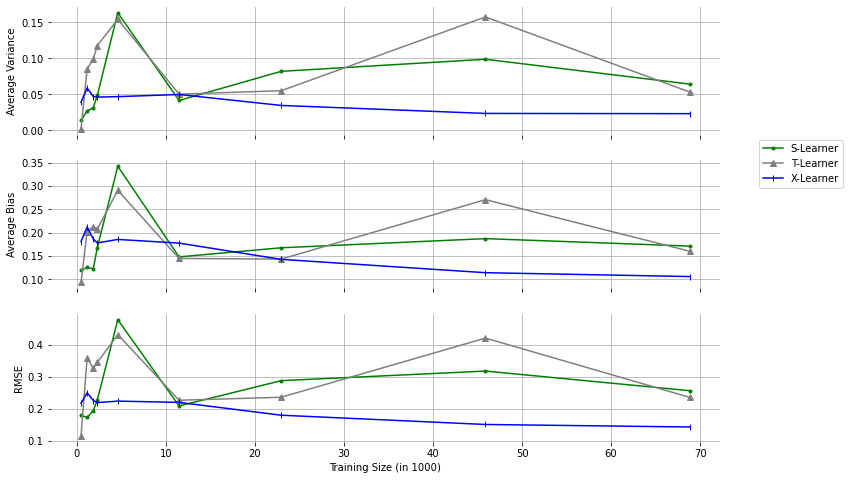

In [125]:
#MLP
s = time.time()
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0,len1,Xtrain, ytrain = get_sample(i)
    gt_curr,cate_t_curr,cate_s_curr,cate_x_curr = np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t)
    for j in range(N):
        gt_curr += learner_t_gt.get_cate2(Xtrain,ytrain,Xtest,len0, len1,0).reshape(-1)
        learner_t = BaseTClassifier(learner0=MLPClassifier(max_iter=300), learner1=MLPClassifier(max_iter=300), type_=1)
        cate_t_curr += learner_t.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1)
        learner_s = BaseSClassifier(learner=MLPClassifier(max_iter=300), type_=1)
        cate_s_curr += learner_s.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1)
        learner_x = BaseXClassifier(learner=MLPClassifier(max_iter=300), cate_learner=RandomForestRegressor(), prospensity_learner=MLPClassifier(max_iter=300))
        cate_x_curr += learner_x.get_cate2(Xtrain,ytrain,Xtest,len0, len1, treatment_test)
    cate_t.append(cate_t_curr/N)
    cate_s.append(cate_s_curr/N)
    cate_x.append(cate_x_curr/N)
    gt.append(gt_curr/N)
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
r3,v3,b3 = eval(cate_x,gt)
visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3)
print(time.time()-s)

25.363439321517944


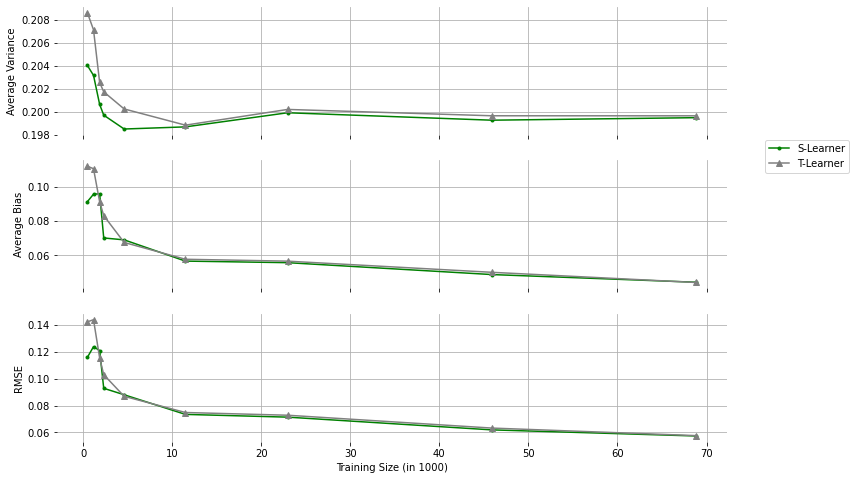

In [124]:
# honest rf (not replace the existing outcomes)
s = time.time()
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0,len1,Xtrain, ytrain = get_sample(i)
    gt_curr,cate_t_curr,cate_s_curr,cate_x_curr = np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t),np.tile(0.0,t)
    for j in range(N):
        gt_curr += learner_t_gt.get_cate_2(Xtrain,ytrain,Xtest,ytest,len0, len1,treatment_test,0).reshape(-1)
        learner_t = BaseTClassifier(learner0=RegressionForest(), learner1=RegressionForest(), type_=1)
        cate_t_curr += learner_t.get_cate_2(Xtrain,ytrain,Xtest,ytest,len0, len1,treatment_test).reshape(-1)
        learner_s = BaseSClassifier(learner=RegressionForest(), type_=1)
        cate_s_curr += learner_s.get_cate_2(Xtrain,ytrain,Xtest,ytest,len0, len1,treatment_test).reshape(-1)
    cate_t.append(cate_t_curr/N)
    cate_s.append(cate_s_curr/N)
    gt.append(gt_curr/N)
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
visualize2(r1,v1,b1,r2,v2,b2)
print(time.time()-s)